<table>
 <tr align=left><td><img align=left src="./images/CC-BY.png">
 <td>Text provided under a Creative Commons Attribution license, CC-BY. All code is made available under the FSF-approved MIT license. (c) Kyle T. Mandli</td>
</table>

In [2]:
%matplotlib inline
import numpy
import matplotlib.pyplot as plt

# Numerical Solution to ODE Initial Value Problems

Many physical, biological, and societal systems can be written as a system of ordinary differential equations (ODEs).  In the case where the initial state (value) is know the problems can be written as

$$\frac{\text{d} \vec{u}}{\text{d}t} = \vec{f}(t, \vec{u}) ~~~~ \vec{u}(0) = \vec{u}_0$$

where
 - $\vec{u}(t)$ is the state vector
 - $\vec{f}(t, \vec{u})$ is a vector-valued function that controls the growth of $\vec{u}$ with time
 - $\vec{u}(0)$ is the initial condition at time $t = 0$

#### Examples:  Simple radioactive decay
$\vec{u} = [c]$
   
$$\frac{\text{d} c}{\text{d}t} = -\lambda c ~~~~ c(0) = c_0$$
   

which has solutions of the form $c(t) = c_0 e^{-\lambda t}$

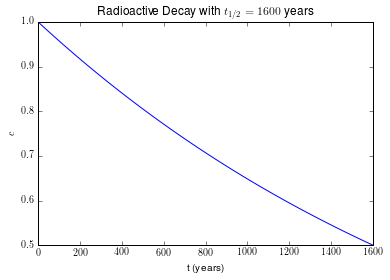

In [3]:
t = numpy.linspace(0.0, 1.6e3, 100)
c_0 = 1.0
decay_constant = numpy.log(2.0) / 1600.0

fig = plt.figure()
axes = fig.add_subplot(1, 1, 1)
axes.plot(t, 1.0 * numpy.exp(-decay_constant * t))

axes.set_title("Radioactive Decay with $t_{1/2} = 1600$ years")
axes.set_xlabel('t (years)')
axes.set_ylabel('$c$')
axes.set_ylim((0.5,1.0))
plt.show()

#### Examples:  Complex radioactive decay (or chemical system).

Chain of decays from one species to another.

$$\begin{aligned}
    \frac{\text{d} c_1}{\text{d}t} &= -\lambda_1 c_1 \\
    \frac{\text{d} c_2}{\text{d}t} &= \lambda_1 c_1 - \lambda_2 c_2 \\
    \frac{\text{d} c_2}{\text{d}t} &= \lambda_2 c_3 - \lambda_3 c_3 
\end{aligned}$$

$$\frac{\text{d} \vec{u}}{\text{d}t} = \frac{\text{d}}{\text{d}t}\begin{bmatrix} c_1 \\ c_2 \\ c_3 \end{bmatrix} = 
\begin{bmatrix} 
    -\lambda_1 & 0 & 0 \\
    \lambda_1 & -\lambda_2 & 0 \\
    0 & \lambda_2 & -\lambda_3
\end{bmatrix} \begin{bmatrix} c_1 \\ c_2 \\ c_3 \end{bmatrix}$$

$$\frac{\text{d} \vec{u}}{\text{d}t} = A \vec{u}$$

For systems of equations like this the general solution to the ODE is the matrix exponential:

$$\vec{u}(t) = \vec{u}_0 e^{A t}$$

#### Examples: Van der Pol Oscillator

$$y'' - \mu (1 - y^2) y' + y = 0~~~~~\text{with}~~~~ y(0) = y_0, ~~~y'(0) = v_0$$
 
$$\vec{u} = \begin{bmatrix} y \\ y' \end{bmatrix} = \begin{bmatrix} u_1 \\ u_2 \end{bmatrix}$$
   
$$\frac{\text{d}}{\text{d}t} \begin{bmatrix} u_1 \\ u_2 \end{bmatrix} = \begin{bmatrix} u_2 \\ \mu (1 - u_1^2) u_2 - u_1 \end{bmatrix} = \vec{f}(t, \vec{u})$$

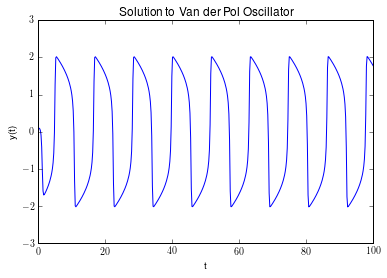

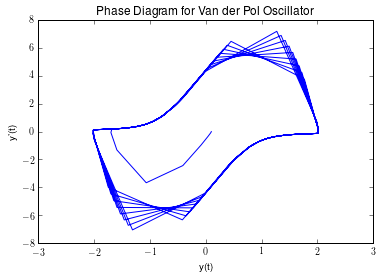

In [4]:
import scipy.integrate as integrate

def f(t, u, mu=5):
    return numpy.array([u[1], mu * (1.0 - u[0]**2) * u[1] - u[0]])

t = numpy.linspace(0.0, 100, 500)
u = numpy.empty((2, 500))
u[:, 0] = [0.1, 0.0]

integrator = integrate.ode(f)
integrator.set_integrator("dopri5")
integrator.set_initial_value(u[:, 0])

for (n, t_n) in enumerate(t[1:]):
    integrator.integrate(t_n)
    if not integrator.successful():
        break
    u[:, n + 1] = integrator.y
    
fig = plt.figure()
axes = fig.add_subplot(1, 1, 1)

axes.plot(t, u[0,:])
axes.set_title("Solution to Van der Pol Oscillator")
axes.set_xlabel("t")
axes.set_ylabel("y(t)")

fig = plt.figure()
axes = fig.add_subplot(1, 1, 1)

axes.plot(u[0,:], u[1, :])
axes.set_title("Phase Diagram for Van der Pol Oscillator")
axes.set_xlabel("y(t)")
axes.set_ylabel("y'(t)")

plt.show()

#### Examples:  Particle tracking in a fluid

$$\frac{\text{d} \vec{X}}{\text{d}t} = \vec{V}(t, \vec{X})$$

In fact all ODE IVP systems can be thought of as tracking particles through a flow field (dynamical system).  In 1-dimension the flow "manifold" we are on is fixed by the initial condition.

## Basic Stepping Schemes

Looking back at our work on numerical differentiation why not approximate the derivative as a finite difference:

$\frac{u(t + \Delta t) - u(t)}{\Delta t} = f(t, u)$

We still need to decide how to evaluate the $f(t, u)$ term however.  Lets look at this from a perspective of quadrature, take the intergral of both sides:

$\begin{aligned}\int^{t + \Delta t}_t \frac{\text{d} u}{\text{d}\tilde{t}} d\tilde{t} &= \int^{t + \Delta t}_t f(t, u) d\tilde{t} \\
u(t + \Delta t) - u(t) &= \Delta t f(t, u(t))
\frac{u(t + \Delta t) - u(t)}{\Delta t} &= f(t, u(t))
\end{aligned}$

where we have used a left-sided quadrature rule for the integral on the right.  Introducing some notation to simpify things

$t_0 = 0$

$t_1 = t_0 + \Delta t$

$t_n = t_{n-1} + \Delta t = n \Delta t + t_0$

$u_0 = u(t_0)$

$u_1 = u(t_1)$

$u_n = u(t_n)$

we can rewrite our scheme as

$\frac{u_{n+1} - u_n}{\Delta t} = f(t_n, u_n)$

or

$u_{n+1} = u_n + \Delta t f(t_n, u_n)$

which is known as the *forward Euler method*.  In essence we are approximating the derivative with the value of the function at the point we are at $t_n$.

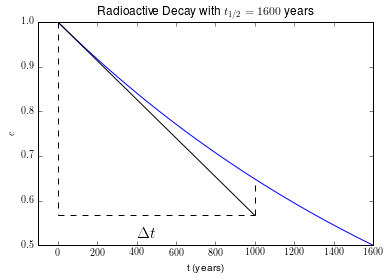

In [5]:
t = numpy.linspace(0.0, 1.6e3, 100)
c_0 = 1.0
decay_constant = numpy.log(2.0) / 1600.0

fig = plt.figure()
axes = fig.add_subplot(1, 1, 1)
axes.plot(t, c_0 * numpy.exp(-decay_constant * t), label="True Solution")

# Plot Euler step
dt = 1e3
u_np = c_0 + dt * (-decay_constant * c_0)
axes.plot((0.0, dt), (c_0, u_np), 'k')
axes.plot((dt, dt), (u_np, c_0 * numpy.exp(-decay_constant * dt)), 'k--')
axes.plot((0.0, 0.0), (c_0, u_np), 'k--')
axes.plot((0.0, dt), (u_np, u_np), 'k--')
axes.text(400, u_np - 0.05, '$\Delta t$', fontsize=16)

axes.set_title("Radioactive Decay with $t_{1/2} = 1600$ years")
axes.set_xlabel('t (years)')
axes.set_ylabel('$c$')
axes.set_xlim(-1e2, 1.6e3)
axes.set_ylim((0.5,1.0))
plt.show()

A similar method can be derived if we consider instead using the second order accurate central difference:

$$\frac{u_{n+1} - u_{n-1}}{2\Delta t} = f(t_{n}, u_{n})$$

this method is known as the leap-frog method.  Note that the way we have written this method requires a previous function evaluation and technically is a "multi-step" method although we do not actually use the current evaluation.

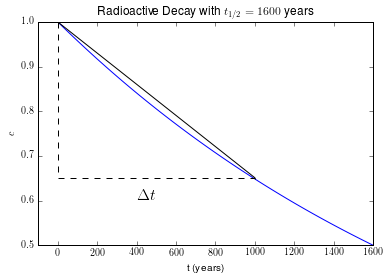

In [6]:
t = numpy.linspace(0.0, 1.6e3, 100)
c_0 = 1.0
decay_constant = numpy.log(2.0) / 1600.0

fig = plt.figure()
axes = fig.add_subplot(1, 1, 1)
axes.plot(t, c_0 * numpy.exp(-decay_constant * t), label="True Solution")

# Plot Euler step
dt = 1e3
u_np = c_0 + dt * (-decay_constant * c_0 * numpy.exp(-decay_constant * dt / 2.0))
axes.plot((0.0, dt), (c_0, u_np), 'k')
axes.plot((dt, dt), (u_np, c_0 * numpy.exp(-decay_constant * dt)), 'k--')
axes.plot((0.0, 0.0), (c_0, u_np), 'k--')
axes.plot((0.0, dt), (u_np, u_np), 'k--')
axes.text(400, u_np - 0.05, '$\Delta t$', fontsize=16)

axes.set_title("Radioactive Decay with $t_{1/2} = 1600$ years")
axes.set_xlabel('t (years)')
axes.set_ylabel('$c$')
axes.set_xlim(-1e2, 1.6e3)
axes.set_ylim((0.5,1.0))
plt.show()

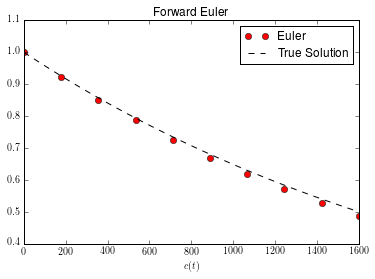

In [7]:
c_0 = 1.0
decay_constant = numpy.log(2.0) / 1600.0
f = lambda t, u: -decay_constant * u

t_exact = numpy.linspace(0.0, 1.6e3, 100)
u_exact = c_0 * numpy.exp(-decay_constant * t_exact)

# Implement Euler
t_euler = numpy.linspace(0.0, 1.6e3, 10)
delta_t = t_euler[1] - t_euler[0]
u_euler = numpy.empty(t_euler.shape)
u_euler[0] = c_0
for (n, t_n) in enumerate(t_euler[:-1]):
    u_euler[n + 1] = u_euler[n] + delta_t * f(t_n, u_euler[n])

fig = plt.figure()
axes = fig.add_subplot(1, 1, 1)
axes.plot(t_euler, u_euler, 'or', label="Euler")
axes.plot(t_exact, u_exact, 'k--', label="True Solution")

axes.set_title("Forward Euler")
axes.set_xlabel("t (years)")
axes.set_xlabel("$c(t)$")
axes.set_ylim((0.4,1.1))
axes.legend()
plt.show()

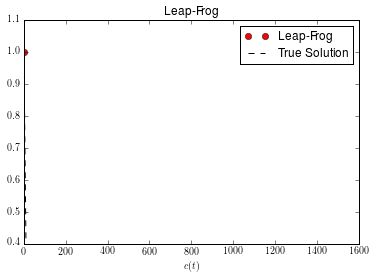

In [8]:
c_0 = 1.0
# decay_constant = numpy.log(2.0) / 1600.0
decay_constant = numpy.log(2.0)
f = lambda t, u: -decay_constant * u

t_exact = numpy.linspace(0.0, 1.6e3, 100)
# t_exact = numpy.linspace(0.0, 1.0, 100)
u_exact = c_0 * numpy.exp(-decay_constant * t_exact)

# Implement leap-frog
t_leapfrog = numpy.linspace(0.0, 1.6e3, 10)
# t_leapfrog = numpy.linspace(0.0, 1.0, 100)
delta_t = t_leapfrog[1] - t_leapfrog[0]
u_leapfrog = numpy.empty(t_leapfrog.shape)
u_leapfrog[0] = c_0
# First evaluation use Euler to get us going
u_leapfrog[1] = u_leapfrog[0] + delta_t * f(t_leapfrog[0], u_leapfrog[0])
for n in xrange(1, t_leapfrog.shape[0] - 1):
    u_leapfrog[n + 1] = u_leapfrog[n - 1] + 2.0 * delta_t * f(t[n], u_leapfrog[n])

fig = plt.figure()
axes = fig.add_subplot(1, 1, 1)
axes.plot(t_leapfrog, u_leapfrog, 'or', label="Leap-Frog")
axes.plot(t_exact, u_exact, 'k--', label="True Solution")

axes.set_title("Leap-Frog")
axes.set_xlabel("t (years)")
axes.set_xlabel("$c(t)$")
axes.set_ylim((0.4,1.1))
axes.legend()
plt.show()

## Error Analysis of ODE Methods

At this point it is also helpful to introduce more notation to distinguish between the true solution to the ODE $u(t_n)$ and the approximated value which we will denote $U_n$.

**Definition:** We define the *truncation error* of a scheme by

$$T(t, u; \Delta t) = \frac{1}{\Delta t} [U_{n+1} - u(t + \Delta t)]$$

**Definition:** A method is called *consistent* if $\lim_{\Delta t \rightarrow 0} T(t, u; \Delta t) = 0$.

**Definition:** We say that a method is *order* $p$ accurate if

$$||T(t, u; \Delta t) || \leq C \Delta t^p$$

uniformally on $t \in [0, T]$.  This can also be written as $T(t, u; \Delta t) = \mathcal{O}(\Delta t^p)$.  Note that a method is consistent if $p > 0$.

### Error Analysis of Forward Euler

We can analyze the error and convergence order of forward Euler by considering the Taylor series centered at $t_n$:

$u(t) = u(t_n) + (t - t_n) u'(t_n) + \frac{u''(t_n)}{2} (t - t_n)^2 + \mathcal{O}((t-t_n)^3)$

Evaluating this series at $t_{n+1}$ gives

$\begin{aligned}
u(t_{n+1}) &= u(t_n) + (t_{n+1} - t_n) u'(t_n) + \frac{u''(t_n)}{2} (t_{n+1} - t_n)^2 + \mathcal{O}((t_{n+1}-t_n)^3)\\
&=u_n + \Delta t f(t_n, u_n) + \frac{u''(t_n)}{2} \Delta t^2 + \mathcal{O}(\Delta t^3)
\end{aligned}$

From the definition of truncation error we can use our Taylor series expression and find the truncation error to be

$\begin{aligned}
T(t, u; \Delta t) &= \frac{1}{\Delta t} [U_{n+1} - u(t + \Delta t)] \\
&= \frac{1}{\Delta t} \left[ u_n + \Delta t f(t_n, u_n) - \left( u_n + \Delta t f(t_n, u_n) + \frac{u''(t_n)}{2} \Delta t^2 + \mathcal{O}(\Delta t^3) \right )\right ] \\
&= \frac{1}{\Delta t} \left[ - \frac{u''(t_n)}{2} \Delta t^2 - \mathcal{O}(\Delta t^3) \right ] \\
&= - \frac{u''(t_n)}{2} \Delta t - \mathcal{O}(\Delta t^2)
\end{aligned}$

This implies that forwar Euler is first order accurate and therefore consistent.

### Error Analysis of Leap-Frog Method

To easily analyze this method we will expand the Taylor series from before to another order and evaluate at both the needed positions:

$u(t) = u(t_n) + (t - t_n) u'(t_n) + (t - t_n)^2 \frac{u''(t_n)}{2}  + (t - t_n)^3 \frac{u'''(t_n)}{6} + \mathcal{O}((t-t_n)^4)$

leading to 

$\begin{aligned}
u(t_{n+1}) &= u_n + \Delta t f_n + \Delta t^2 \frac{u''(t_n)}{2}  + \Delta t^3 \frac{u'''(t_n)}{6} + \mathcal{O}(\Delta t^4)\\
u(t_{n-1}) &= u_n - \Delta t f_n + \Delta t^2 \frac{u''(t_n)}{2}  - \Delta t^3 \frac{u'''(t_n)}{6} + \mathcal{O}(\Delta t^4)
\end{aligned}$

Plugging this into our definition of the truncation error along with the leap-frog method definition leads to

$\begin{aligned}
T(t, u; \Delta t) &=\frac{1}{\Delta t} \left [\left(u_n - \Delta t f_n + \Delta t^2 \frac{u''(t_n)}{2}  - \Delta t^3 \frac{u'''(t_n)}{6} + \mathcal{O}(\Delta t^4)\right) + 2\Delta t f_n - \left(u_n + \Delta t f_n + \Delta t^2 \frac{u''(t_n)}{2}  + \Delta t^3 \frac{u'''(t_n)}{6} + \mathcal{O}(\Delta t^4) \right )\right ] \\
&=\frac{1}{\Delta t} \left [- \Delta t^3 \frac{u'''(t_n)}{3} + \mathcal{O}(\Delta t^4) \right ] \\
&=- \Delta t^2 \frac{u'''(t_n)}{3} + \mathcal{O}(\Delta t^3)
\end{aligned}$

Therefore the method is second order accurate and is consistent theoretically.  In practice it's a bit more complicated than that.


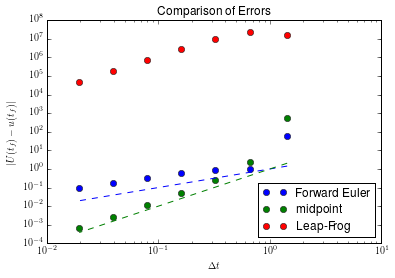

In [9]:
# Compare accuracy between Euler and Leap-Frog
f = lambda t, u: -u
u_exact = lambda t: numpy.exp(-t)

t_f = 10.0
num_steps = [2**n for n in xrange(3,10)]
delta_t = numpy.empty(len(num_steps))
error_euler = numpy.empty(len(num_steps))
error_midpoint = numpy.empty(len(num_steps))
error_leapfrog = numpy.empty(len(num_steps))

for (i, N) in enumerate(num_steps):
    t = numpy.linspace(0, t_f, N)
    delta_t[i] = t[1] - t[0]
    
    # Compute Euler solution
    u_euler = numpy.empty(t.shape)
    u_euler[0] = 1.0
    for n in xrange(t.shape[0] - 1):
        u_euler[n+1] = u_euler[n] + delta_t[i] * f(t[n], u_euler[n])
        
    # Compute midpoint
    u_midpoint = numpy.empty(t.shape)
    u_midpoint[0] = 1.0
    for n in xrange(t.shape[0] - 1):
        u_midpoint[n+1] = u_midpoint[n] + delta_t[i] * f(t[n] + 0.5 * delta_t[i], 
                                                         u_midpoint[n] + 0.5 * delta_t[i] * f(t[n], u_midpoint[n]))
        
    # Compute Leap-Frog
    u_leapfrog = numpy.empty(t.shape)
    u_leapfrog[0] = 1.0
    u_leapfrog[1] = u_euler[1]
    for n in xrange(1, t.shape[0] - 1):
        u_leapfrog[n+1] = u_leapfrog[n-1] + 2.0 * delta_t[i] * f(t_n, u_leapfrog[n])
        
    # Compute error for each
    error_euler[i] = numpy.abs(u_euler[-1] - u_exact(t_f)) / numpy.abs(u_exact(t_f))
    error_midpoint[i] = numpy.abs(u_midpoint[-1] - u_exact(t_f)) / numpy.abs(u_exact(t_f))
    error_leapfrog[i] = numpy.abs(u_leapfrog[-1] - u_exact(t_f)) / numpy.abs(u_exact(t_f))
    
# Plot error vs. delta_t
fig = plt.figure()
axes = fig.add_subplot(1, 1, 1)

axes.loglog(delta_t, error_euler, 'bo', label='Forward Euler')
axes.loglog(delta_t, error_midpoint, 'go', label='midpoint')
axes.loglog(delta_t, error_leapfrog, 'ro', label="Leap-Frog")

axes.loglog(delta_t, delta_t**(1.0), '--b')
axes.loglog(delta_t, delta_t**(2.0), '--g')

axes.legend(loc=4)
axes.set_title("Comparison of Errors")
axes.set_xlabel("$\Delta t$")
axes.set_ylabel("$|U(t_f) - u(t_f)|$")

plt.show()

## Runge-Kutta Methods

One way to derive higher-order ODE solvers is by computing intermediate stages.  These are not *multi-step* methods as they still only require information from the current time step but they raise the order of accuracy by adding *stages*.  These types of methods are called **Runge-Kutta** methods.

### Example:  Two-stage Runge-Kutta Methods

The basic idea behind the simplest of the Runge-Kutta methods is to approximate the solution at $t_n + \Delta t / 2$ via Euler's method and use this in the function evaluation for the final update.

$U^* = U^n + \frac{1}{2} \Delta t f(U^n)$

$U^{n+1} = U^n + \Delta t f(U^*) = U^n + \Delta t f(U^n + \frac{1}{2} \Delta t f(U^n))$

The truncation error can be computed similarly to how we did so before but we do need to figure out how to compute the derivative inside of the function.  Note that due to $f(u(t_n)) = u'(t_n)$ that differentiating this leads to $f'(u(t_n)) u'(t_n) = u''(t_n)$ leading to

$\begin{aligned}
    f\left(u(t_n) + \frac{1}{2} \Delta t f(u(t_n)) \right ) = f\left(u(t_n) +\frac{1}{2} \Delta t u'(t_n) \right ) \\
    &= f(u(t_n)) + \frac{1}{2} \Delta t u'(t_n) f'(u(t_n)) + \frac{1}{8} \Delta t^2 (u'(t_n))^2 f''(u(t_n)) + \mathcal{O}(\Delta t^3) \\
    &=u'(t_n) + \frac{1}{2} \Delta t u''(t_n) + \mathcal{O}(\Delta t^2)
\end{aligned}$

Going back to the truncation error we have

$\begin{aligned}
    T(t, u; \Delta t) &= \frac{1}{\Delta t} \left[u_n + \Delta t f\left(u_n + \frac{1}{2} \Delta t f(u_n)\right) - \left(u_n + \Delta t f(t_n, u_n) + \frac{u''(t_n)}{2} \Delta t^2 + \mathcal{O}(\Delta t^3) \right ) \right] \\
    &=\frac{1}{\Delta t} \left[\Delta t u'(t_n) + \frac{1}{2} \Delta t^2 u''(t_n) + \mathcal{O}(\Delta t^3) - \Delta t u'(t_n) - \frac{u''(t_n)}{2} \Delta t^2 + \mathcal{O}(\Delta t^3) \right] \\
    &= \mathcal{O}(\Delta t^2)
\end{aligned}$

so this method is second order accurate.

### Example:  4-stage Runge-Kutta Method

$\begin{aligned}
    Y_1 &= U_n \\
    Y_2 &= U_n + \frac{1}{2} \Delta t f(Y_1, t_n) \\
    Y_3 &= U_n + \frac{1}{2} \Delta t f(Y_2, t_n + \Delta t / 2) \\
    Y_4 &= U_n + \Delta t f(Y_3, t_n + \Delta t / 2) \\
    U_{n+1} &= U_n + \frac{\Delta t}{6} \left [f(Y_1, t_n) + 2 f(Y_2, t_n + \Delta t / 2) + 2 f(Y_3, t_n + \Delta t/2) + f(Y_4, t_n + \Delta t) \right ]
\end{aligned}$

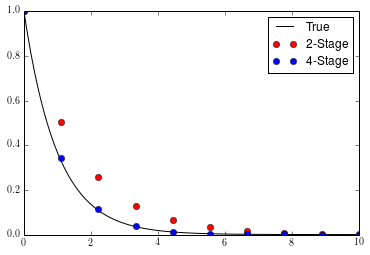

In [10]:
# Implement and compare the two-stage and 4-stage Runge-Kutta methods
f = lambda t, u: -u

t_exact = numpy.linspace(0.0, 10.0, 100)
u_exact = numpy.exp(-t_exact)

N = 10
t = numpy.linspace(0, 10.0, N)
delta_t = t[1] - t[0]
u_2 = numpy.empty(t.shape)
u_4 = numpy.empty(t.shape)
u_2[0] = 1.0
u_4[0] = 1.0

for (n, t_n) in enumerate(t[1:]):
    u_2[n+1] = u_2[n] + 0.5 * delta_t * f(t_n, u_2[n])
    u_2[n+1] = u_2[n] + delta_t * f(t_n, u_2[n+1])
    y_1 = u_4[n]
    y_2 = u_4[n] + 0.5 * delta_t * f(t_n + 0.5 * delta_t, y_1)
    y_3 = u_4[n] + 0.5 * delta_t * f(t_n + 0.5, y_2)
    y_4 = u_4[n] + delta_t * f(t_n + 0.5 * delta_t, y_3)
    u_4[n+1] = u_4[n] + delta_t / 6.0 * (f(t_n, y_1) + 2.0 * f(t_n + 0.5 * delta_t, y_2) + 2.0 * f(t_n + 0.5 * delta_t, y_3) + f(t_n + delta_t, y_4))
    
fig = plt.figure()
axes = fig.add_subplot(1, 1, 1)

axes.plot(t_exact, u_exact, 'k', label="True")
axes.plot(t, u_2, 'ro', label="2-Stage")
axes.plot(t, u_4, 'bo', label="4-Stage")
axes.legend(loc=1)

plt.show()

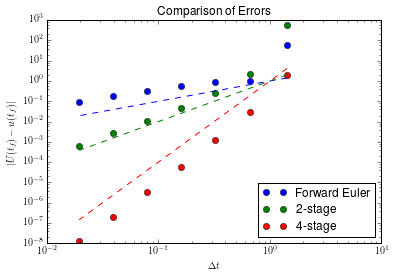

In [11]:
# Compare accuracy between Euler and Leap-Frog
f = lambda t, u: -u
u_exact = lambda t: numpy.exp(-t)

t_f = 10.0
num_steps = [2**n for n in xrange(3,10)]
delta_t = numpy.empty(len(num_steps))
error_euler = numpy.empty(len(num_steps))
error_2 = numpy.empty(len(num_steps))
error_4 = numpy.empty(len(num_steps))

for (i, N) in enumerate(num_steps):
    t = numpy.linspace(0, t_f, N)
    delta_t[i] = t[1] - t[0]
    
    # Compute Euler solution
    u_euler = numpy.empty(t.shape)
    u_euler[0] = 1.0
    for (n, t_n) in enumerate(t[1:]):
        u_euler[n+1] = u_euler[n] + delta_t[i] * f(t_n, u_euler[n])
        
    # Compute 2 and 4-stage
    u_2 = numpy.empty(t.shape)
    u_4 = numpy.empty(t.shape)
    u_2[0] = 1.0
    u_4[0] = 1.0
    for (n, t_n) in enumerate(t[1:]):
        u_2[n+1] = u_2[n] + 0.5 * delta_t[i] * f(t_n, u_2[n])
        u_2[n+1] = u_2[n] + delta_t[i] * f(t_n, u_2[n+1])
        y_1 = u_4[n]
        y_2 = u_4[n] + 0.5 * delta_t[i] * f(t_n + 0.5 * delta_t[i], y_1)
        y_3 = u_4[n] + 0.5 * delta_t[i] * f(t_n + 0.5, y_2)
        y_4 = u_4[n] + delta_t[i] * f(t_n + 0.5 * delta_t[i], y_3)
        u_4[n+1] = u_4[n] + delta_t[i] / 6.0 * (f(t_n, y_1) + 2.0 * f(t_n + 0.5 * delta_t[i], y_2) + 2.0 * f(t_n + 0.5 * delta_t[i], y_3) + f(t_n + delta_t[i], y_4))
        
    # Compute error for each
    error_euler[i] = numpy.abs(u_euler[-1] - u_exact(t_f)) / numpy.abs(u_exact(t_f))
    error_2[i] = numpy.abs(u_2[-1] - u_exact(t_f)) / numpy.abs(u_exact(t_f))
    error_4[i] = numpy.abs(u_4[-1] - u_exact(t_f)) / numpy.abs(u_exact(t_f))
    
# Plot error vs. delta_t
fig = plt.figure()
axes = fig.add_subplot(1, 1, 1)

axes.loglog(delta_t, error_euler, 'bo', label='Forward Euler')
axes.loglog(delta_t, error_2, 'go', label='2-stage')
axes.loglog(delta_t, error_4, 'ro', label="4-stage")

axes.loglog(delta_t, delta_t**(1.0), '--b')
axes.loglog(delta_t, delta_t**(2.0), '--g')
axes.loglog(delta_t, delta_t**(4.0), '--r')

axes.legend(loc=4)
axes.set_title("Comparison of Errors")
axes.set_xlabel("$\Delta t$")
axes.set_ylabel("$|U(t_f) - u(t_f)|$")

plt.show()

## Linear Multi-Step Methods

Multi-step methods (as introduced via the leap-frog method) are ODE methods that require multiple time step evaluations to work.  Some of the advanatages of using a multi-step method rather than one-step method included

 - Taylor series methods require differentiating the given equation which can be cumbersome and difficult to impelent
 - One-step methods at higher order often require the evaluation of the function $f$ many times
 
Disadvantages

 - Methods are not self-starting, i.e. they require other methods to find the initial values
 - The time step $\Delta t$ in one-step methods can be changed at any time while multi-step methods this is much more complex
 
### General Linear Multi-Step Methods

All linear multi-step methods can be written as the linear combination of past, present and future solutions:

$\sum^r_{j=0} \alpha_j U_{n+j} = \Delta t \sum^r_{j=0} \beta_j f(U_{n+j}, t_{n+j})$

If $\beta_r = 0$ then the method is explicit (only requires previous time steps).  Note that the coefficients are not unique as we can multiply both sides by a constant.  In practice a normalization of $\alpha_r = 1$ is used.

#### Example: Adams Methods

$U_{n+r} = U_{n+r-1} + \Delta t \sum^r_{j=0} \beta_j f(U_{n+j}).$

All these methods have $\alpha_r = 1$, $\alpha_{r-1} = -1$ and $\alpha_j=0$ for $j < r - 1$.

### Adams-Bashforth Methods
The **Adams-Bashforth** methods are explicit solvers that maximize the order of accuracy given a number of steps $r$.  This is accomplished by looking at the Taylor series and picking the coefficients $\beta_j$ to elliminate as many terms in the Taylor series as possible.

 - 1-step: $U_{n+1} = U_n +\Delta t / 2 (f(U_n) + f(U_{n+1}))$
 - 2-step: $U_{n+2} = U_{n+1} + \Delta t / 2 (-f(U_n) + 3 f(U_{n+1}))$
 - 3-step: $U_{n+3} = U_{n+2} + \Delta t / 12 (5 f(U_n) - 16 f(U_{n+1}) + 23 f(U_{n+2}))$
 

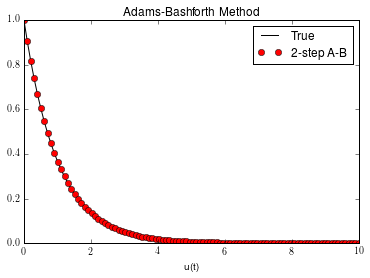

In [12]:
# Use 2-step Adams-Bashforth to compute solution
f = lambda t, u: -u

t_exact = numpy.linspace(0.0, 10.0, 100)
u_exact = numpy.exp(-t_exact)

N = 100
t = numpy.linspace(0, 10.0, N)
delta_t = t[1] - t[0]
u_ab2 = numpy.empty(t.shape)

# Use RK-2 to start the method
u_ab2[0] = 1.0
u_ab2[1] = u_ab2[0] + 0.5 * delta_t * f(t[0], u_ab2[0])
u_ab2[1] = u_ab2[0] + delta_t * f(t[0], u_ab2[1])
for n in xrange(0,len(t)-2):
    u_ab2[n+2] = u_ab2[n + 1] + delta_t / 2.0 * (-f(t[n], u_ab2[n]) + 3.0 * f(t[n+1], u_ab2[n+1]))
    
fig = plt.figure()
axes = fig.add_subplot(1, 1, 1)

axes.plot(t_exact, u_exact, 'k', label="True")
axes.plot(t, u_ab2, 'ro', label="2-step A-B")

axes.set_title("Adams-Bashforth Method")
axes.set_xlabel("t")
axes.set_xlabel("u(t)")
axes.legend(loc=1)

plt.show()

### Adams-Moulton Methods
The **Adams-Moulton** methods are the implicit versions of the Adams-Bashforth methods.  Since this gives one additional parameter to use $\beta_r$ these methods are generally one order of accuracy greater than their counterparts.

 - 1-step: $U_{n+1} = U_n + \Delta t / 2(f(U_n) + f(U_{n+1}))$
 - 2-step: $U_{n+2} = U_{n+1} + \Delta t / 12 (-f(U_n) + 8f(U_{n+1}) + 5f(U_{n+2})$
 - 3-step: $U_{n+3} = U_{n+2} + \Delta t / 24 (f(U_n) - 5f(U_{n+1}) + 19f(U_{n+2}) + 9f(U_{n+3})$
 
### Truncation Error for Multi-Step Methods

We can again find the truncation error in general for linear multi-step methods:

$\begin{aligned}
T(t, u; \Delta t) &= \frac{1}{\Delta t} \left [\sum^r_{j=0} \alpha_j u_{n+j} - \Delta t \sum^r_{j=0} \beta_j f(u_{n+j}, t_{n+j}) \right ]
\end{aligned}$

Using the general expansion and evalution of the Taylor series about $t_n$ we have

$\begin{aligned}
    u(t_{n+j}) &= u(t_n) + j \Delta t u'(t_n) + \frac{1}{2} (j \Delta t)^2 u''(t_n) + \mathcal{O}(\Delta t^3) \\
    u'(t_{n+j}) &= u'(t_n) + j \Delta t u''(t_n) + \frac{1}{2} (j \Delta t)^2 u'''(t_n) + \mathcal{O}(\Delta t^3)
\end{aligned}$

leading to

$\begin{aligned}
T(t, u; \Delta t) &= \frac{1}{\Delta t}\left( \sum^r_{j=0} \alpha_j\right) u_{n+j} + \left(\sum^r_{j=0} (j\alpha_j - \beta_j)\right) u'(t_n) + \Delta t \left(\sum^r_{j=0} \left (\frac{1}{2}j^2 \alpha_j - j \beta_j \right) \right) u''(t_n) \\
&~~~~~~~+ \cdots + \Delta t^{q - 1} \left (\frac{1}{q!} \left(j^q \alpha_j - \frac{1}{(q-1)!} j^{q-1} \beta_j \right) \right) u^{(q)}(t_n) + \cdots
\end{aligned}$

The method is *consistent* if the first two terms of the expansion vanish, i.e. $\sum^r_{j=0} \alpha_j = 0$ and $\sum^r_{j=0} j \alpha_j = \sum^r_{j=0} \beta_j$.

### Predictor-Corrector Methods

One way to simplify the Adams-Moulton methods so that implicit evaluations are not needed is by estimating the required implicit function evaluations with an explicit method.  These are often called **predictor-corrector** methods as the explicit method provides a *prediction* of what the solution might be and the not explicit *corrector* step works to make that estimate more accurate.

#### Example: One-Step Adams-Bashforth-Moulton

Use the One-step Adams-Bashforth method to predict the value of $U_{n+1}$ and then use the Adams-Moulton method to correct that value:

$\hat{U}_{n+1} = U_n + \Delta t f(U_n)$

$U_{n+1} = U_n + \frac{1}{2} \Delta t (f(U_n) + f(\hat{U}_{n+1})$

This method is second order accurate. 

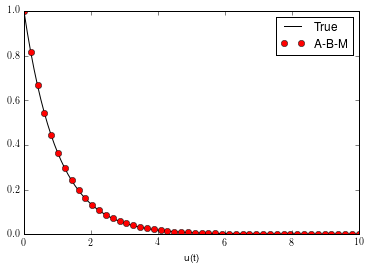

In [13]:
# Implement the Adams-Bashforth-Moulton 2nd order predictor-corrector method
f = lambda t, u: -u

t_exact = numpy.linspace(0.0, 10.0, 100)
u_exact = numpy.exp(-t_exact)

N = 50
t = numpy.linspace(0, 10.0, N)
delta_t = t[1] - t[0]
u_abm2 = numpy.empty(t.shape)


# Use RK-2 to start the method
u_abm2[0] = 1.0
u_abm2[1] = u_abm2[0] + 0.5 * delta_t * f(t_n, u_abm2[0])
u_abm2[1] = u_abm2[0] + delta_t * f(t_n, u_abm2[1])
for n in xrange(len(t) - 1):
    u_abm2[n+1] = u_abm2[n] + delta_t * f(t[n], u_abm2[n])
    u_abm2[n+1] = u_abm2[n] + 0.5 * delta_t * (f(t[n], u_abm2[n]) + f(t[n+1], u_abm2[n+1]))

fig = plt.figure()
axes = fig.add_subplot(1, 1, 1)

axes.plot(t_exact, u_exact, 'k', label="True")
axes.plot(t, u_abm2, 'ro', label="A-B-M")

axes.set_xlabel("t")
axes.set_xlabel("u(t)")
axes.legend(loc=1)

plt.show()

# Convergence

We can think of an ODE method as providing a sequence of approximations $U^N$ where here $N$ is the number of time steps needed to reach the final time of interest $t_f$, in effect we are increasing the resolution of the method.  We then say that a method is convergent if this sequence converges to the true solution at the same time

$$\lim_{N\rightarrow \infty} U^N = u(t_f).$$

We can also define this in a more familiar way in terms of $\Delta t$ such that

$$N \Delta t = t_f ~~~~ \Rightarrow ~~~~ N = \frac{t_f}{\Delta t}$$

so that our definition of convergence becomes

$$\lim_{\Delta t \rightarrow 0} U_{\Delta t} = u(t_f).$$

In general for a method to be convergent it must be

 - **consistent** which as before meant that the local truncation error $T = \mathcal{O}(\Delta t^p)$ where $p > 0$,
 - **zero-stable** which implies that the sum total of the errors as $\Delta t \rightarrow 0$ is bounded and has the same order as $T$ which we know goes to zero as $\Delta t \rightarrow 0$.
 
### Example:  Forward Euler

Consider the simple linear problem

$$\frac{\text{d}u}{\text{d}t} = - \lambda u ~~~~ \text{with}~~~~ u(0) = u_0$$

which we know has the solution $u(t) = u_0 e^{\lambda t}$.  Applying Euler's method to this problem leads to 

$$\begin{aligned}
U_{n+1} &= U_n + \Delta t\lambda U_n \\
&= (1 + \Delta t \lambda) U_n
\end{aligned}$$

We also know the local truncation error is

$$\begin{aligned}
    T^n &= \left (\frac{u(t_{n+1}) - u(t_n)}{\Delta t} \right ) - \lambda u(t_n)\\
    &= \left (u'(t_n) + \frac{1}{2} \Delta t u''(t_n) + \mathcal{O}(\Delta t^2) \right ) - u'(t_n) \\
    &= \frac{1}{2} \Delta t u''(t_n) + \mathcal{O}(\Delta t^2)
\end{aligned}$$

Noting the original definition of $T_n$ we can rewrite the expression for the local truncation error as

$$u(t_{n+1}) = (1 + \Delta t \lambda) u(t_n) + \Delta t T^n$$

which in combination with the application of Euler's method leads to an expression for the global error

$$E^{n+1} = (1+\Delta t \lambda) E^n - \Delta t T^n$$

Expanding this expression out backwards in time to $n=0$ leads to 

$$E^n = (1 + \Delta t \lambda) E^0 - \Delta t \sum^n_{i=1} (1 + \Delta t \lambda)^{n-i} T^{i - 1}.$$

We can now see the importance of the term $(1 + \Delta t \lambda)$.  We can bound this term by

$e^{\Delta t \lambda} \geq |1 + \Delta t \lambda|$

which then implies the term in the summation can be bounded by

$$|1 + \Delta t \lambda|^{n - i} \leq e^{(n-i) \Delta t |\lambda|} \leq e^{n \Delta t |\lambda||} \leq e^{|\lambda| t_f}$$

Using this expression in the expression for the global error we find

$$\begin{aligned}
    E^n &= (1 + \Delta t \lambda) E^0 - \Delta t \sum^n_{i=1} (1 + \Delta t \lambda)^{n-i} T^{i - 1} \\
    |E^n| &\leq e^{|\lambda| \Delta t} |E^0| - \Delta t \sum^n_{i=1} e^{|\lambda| t_f} |T^{i - 1}| \\
          &\leq e^{|\lambda| t_f} \left(|E^0| - \Delta t \sum^n_{i=1} |T^{i - 1}|\right) \\
          &\leq e^{|\lambda| t_f} \left(|E^0| - n \Delta t \max_{1 \leq i \leq n} |T^{i - 1}|\right)
\end{aligned}$$
In other words the global error is bounded by the original global erro and the maximum one-step error made multiplied by the number of time steps taken.  If $N = \frac{t_f}{\Delta t}$ as before and taking into account the local truncation error we can simplify this expression further to

$$|E^n| \leq e^{|\lambda| t_f} \left[|E^0| + t_f \left(\frac{1}{2} \Delta t |u''| + \mathcal{O}(\Delta t^2)\right ) \right]$$

If we assume that we have used the correct initial condition $u_0$ then $E_0 \rightarrow 0$ as $\Delta t \rightarrow 0$ and we see that the method is truly convergent as 

$$|E^n| \leq e^{|\lambda| t_f} t_f \left(\frac{1}{2} \Delta t |u''| + \mathcal{O}(\Delta t^2)\right ) = \mathcal{O}(\Delta t).$$

## Absolute Stability
Although zero-stability gaurantees stability it is much more difficult to work with in general as the limit $\Delta t \rightarrow 0$ can be difficult to compute.  Instead we often consider a finite $\Delta t$ and examine if the method is stable for this particular choice of $\Delta t$.  This has the practical upside that it will also tell us what particular $\Delta t$ will ensure that our method is indeed stable.

### Example
Consider the problem

$$u'(t) = \lambda (u - \cos t) - \sin t ~~~~\text{with}~~~~ u(0) = 1$$

whose exact solution is 

$$u(t) = \cos t.$$

We can compute an estimate for what $\Delta t$ we need to use by examining the truncation error 

$$\begin{aligned}
    T &= \frac{1}{2} \Delta t u''(t) + \mathcal{O}(\Delta t^2) \\
      &= -\frac{1}{2} \Delta t \cos t + \mathcal{O}(\Delta t^2)
\end{aligned}$$

and therfore

$$|E^n| \leq \Delta t \max_{0 \leq t \leq t_f} |\cos t| = \Delta t.$$

If we want a solution where $|E^n| < 10^{-3}$ then $\Delta t \approx 10^{-3}$.  Turning to the application of Euler's method lets apply this to the case where $\lambda = -10$ and $\lambda = -2100$.

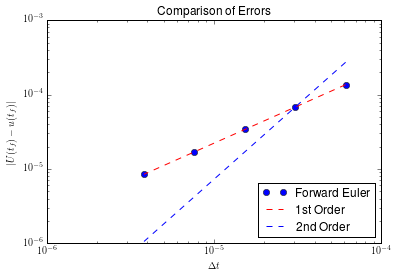

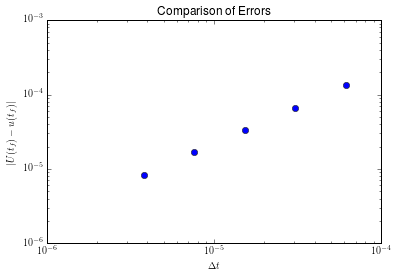

In [14]:
# Compare accuracy between Euler
f = lambda t, lam, u: lam * (u - numpy.cos(t)) - numpy.sin(t)
u_exact = lambda t: numpy.cos(t)

t_f = 2.0
# num_steps = [2**n for n in xrange(3, 20)]
num_steps = [2**n for n in xrange(15,20)]
delta_t = numpy.empty(len(num_steps))
error_10 = numpy.empty(len(num_steps))
error_2100 = numpy.empty(len(num_steps))

for (i, N) in enumerate(num_steps):
    t = numpy.linspace(0, t_f, N)
    delta_t[i] = t[1] - t[0]
    
    # Compute Euler solution
    U = numpy.empty(t.shape)
    U[0] = 1.0
    for (n, t_n) in enumerate(t[1:]):
        U[n+1] = U[n] + delta_t[i] * f(t_n, -10.0, U[n])
    error_10[i] = numpy.abs(U[-1] - u_exact(t_f)) / numpy.abs(u_exact(t_f))
    
    U = numpy.empty(t.shape)
    U[0] = 1.0
    for (n, t_n) in enumerate(t[1:]):
        U[n+1] = U[n] + delta_t[i] * f(t_n, -2100.0, U[n])
    error_2100[i] = numpy.abs(U[-1] - u_exact(t_f)) / numpy.abs(u_exact(t_f))
    
# Plot error vs. delta_t
fig = plt.figure()
axes = fig.add_subplot(1, 1, 1)

axes.loglog(delta_t, error_10, 'bo', label='Forward Euler')

order_C = lambda delta_x, error, order: numpy.exp(numpy.log(error) - order * numpy.log(delta_x))
axes.loglog(delta_t, order_C(delta_t[1], error_10[1], 1.0) * delta_t**1.0, 'r--', label="1st Order")
axes.loglog(delta_t, order_C(delta_t[1], error_10[1], 2.0) * delta_t**2.0, 'b--', label="2nd Order")

axes.legend(loc=4)
axes.set_title("Comparison of Errors")
axes.set_xlabel("$\Delta t$")
axes.set_ylabel("$|U(t_f) - u(t_f)|$")

fig = plt.figure()
axes = fig.add_subplot(1, 1, 1)

axes.loglog(delta_t, error_2100, 'bo', label='Forward Euler')

axes.set_title("Comparison of Errors")
axes.set_xlabel("$\Delta t$")
axes.set_ylabel("$|U(t_f) - u(t_f)|$")

plt.show()

So what went wrong with $\lambda = -2100$?  The global error should go as

$$E^{n+1} = (1 + \Delta t \lambda) E^n - \Delta t T^n$$

If $\Delta t \approx 10^{-3}$ then for the case $\lambda = -10$ the previous global error is multiplied by

$$1 + 10^{-3} \cdot -10 = 0.99$$

which means the contribution from $E^n$ will slowly decrease as we take more time steps.  For the other case we have

$$1 + 10^{-3} \cdot -2100 = -1.1$$

which means that for this $\Delta t$ the error made in previous time steps will grow!  For this not to happen we would have to have $\Delta t < 1 / 2100$ which would lead to convergence again.

### Absolute Stability of the Forward Euler Method

Consider again the simple test problem $u'(t) = \lambda u$.  We know from before that applying Euler's method to this problem leads to an update of the form

$$U_{n+1} = (1 + \Delta t \lambda) U_n.$$

As may have been clear from the last example, we know that if

$$|1 + \Delta t \lambda| \leq 1$$

that the method will be stable, this is called **absolute stability**.  Note that the product of $\Delta t \lambda$ is what matters here and often we consider a **region of absolute stability** on the complex plain defined by the equation outlined where now $z = \Delta t \lambda$.  This allows the values of $\lambda$ to be complex which can be an important case to consider, especially for systems of equations where the $\lambda$s are identified as the eigenvalues.

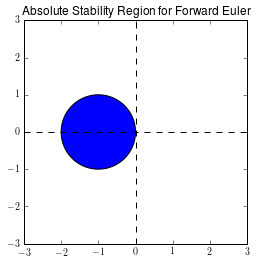

In [15]:
# Plot the region of absolute stability for Forward Euler
fig = plt.figure()
axes = fig.add_subplot(1, 1, 1)

t = numpy.linspace(0.0, 2.0 * numpy.pi, 100)

axes.fill(numpy.cos(t) - 1.0, numpy.sin(t), 'b')
axes.plot([-3, 3],[0.0, 0.0],'k--')
axes.plot([0.0, 0.0],[-3, 3],'k--')
axes.set_xlim((-3, 3.0))
axes.set_ylim((-3,3))
axes.set_aspect('equal')

axes.set_title("Absolute Stability Region for Forward Euler")
plt.show()

### Characteristic Polynomials and Linear Difference Equations

As an short aside, say we wanted to solve

$$\sum^r_{j=0} \alpha_j U_{n+j} = 0$$

given initial conditions $U_0, U_1, \ldots, U_{r-1}$ which has a solution in the general form $U_n = \xi^n$.  Plugging this into the equation we have

$$\sum^r_{j=0} \alpha_j \xi^{n+j} = 0$$

which simplifies to

$$\sum^r_{j=0} \alpha_j \xi^j = 0 $$

by dividing by $\xi^n$.  If $\xi$ then is a root of the polynomial

$$\rho(\xi) = \sum^r_{j=0} \alpha_j \xi^j$$

then $\xi$ solves the equation.

### General Stability Regions for Linear Multistep Methods

Going back to linear multistep methods and applying them in general to our test problem we have

$$\sum^r_{j=0} \alpha_j U_{n+j} = \Delta t \sum^r_{j=0} \beta_j \lambda U_{n+j}$$

which can be written as 

$$\sum^r_{j=0} (\alpha_j - \beta_j \Delta t \lambda) U_{n+j} = 0$$

or using our notation of $z = \Delta t \lambda$ we have

$$\sum^r_{j=0} (\alpha_j - \beta_j z) U_{n+j} = 0.$$

This has a similar form to the linear difference equations considered above!  Letting

$$\rho(\xi) = \sum^r_{j=0} \alpha_j \xi^j$$

and 

$$\sigma(\xi) = \sum^r_{j=0} \beta_j \xi^j$$

we can write the expression above as

$$\pi(\xi, z) = \rho(\xi) - z \sigma(\xi)$$

called the **stability polynomial** of the the linear multi-step method.  It turns out that if the roots $\xi_i$ of this polynomial satisfy

$$|\xi_i| \leq 1$$

then the multi-step method is zero-stable.  We then define the region of absolute stability as the values for $z$ for which this is true.  This approach can also be applied to one-step methods.

### Example:  Forward Euler's Method

Examining forward Euler's method we have

$$\begin{aligned}
    0 &= U_{n+1} - U_n - \Delta t \lambda U_n \\
    &= U_{n+1} - U_n (1 + \Delta t \lambda)\\
    &= \xi - 1 (1 + z)\\
    &=\pi(\xi, z)
\end{aligned}$$

whose root is $\xi = 1 + z$ and we have re-derived the stability region we had found before.

### Absolute Stability of the backward Euler Method

The backward version of Euler's method is defined as

$$U_{n+1} = U_n + \Delta t f(t_{n+1}, U_{n+1}).$$

If we again consider the test problem from before we find that

$$\begin{aligned}
    0 &= U_{n+1} (1 - \Delta t \lambda) - U_n \\
    &= \xi (1 - z) - 1
\end{aligned}$$

which has the root $\xi = \frac{1}{1 - z}$.  We then have

$$\left|\frac{1}{1-z}\right| \leq 1 \leftrightarrow |1 - z| \geq 1$$

so in fact the stability region encompasses the entire complex plane except for a circle centered at $(1, 0)$ of radius 1 implying that the backward Euler method is in fact stable for any choice of $\Delta t$.

## Application to Stiff ODEs

Consider again the ODE we examined before

$$u'(t) = \lambda (u - \cos t) - \sin t$$

except this time with general initial condition $u(t_0) = \eta$.  What happens to solutions that are slightly different from $\eta = 1$ or $t_0 = 0$?  The general solution of the ODE is

$$u(t) = e^{\lambda (t - t_0)} (\eta - \cos t_0)) + \cos t$$.

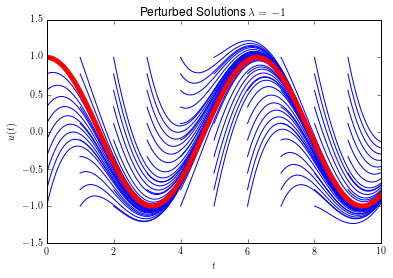

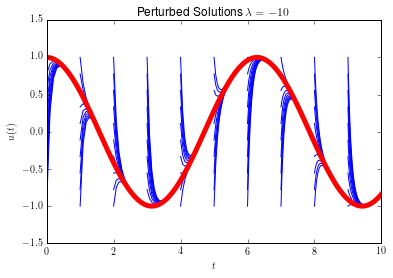

In [16]:
# Plot "hairy" solutions to the ODE
u = lambda t_0, eta, lam, t: numpy.exp(lam * (t - t_0)) * (eta - numpy.cos(t_0)) + numpy.cos(t)

fig = plt.figure()

for lam in [-1, -10]:
    fig = plt.figure()
    axes = fig.add_subplot(1, 1, 1)
    for eta in numpy.linspace(-1, 1, 10):
        for t_0 in numpy.linspace(0.0, 9.0, 10):
            t = numpy.linspace(t_0,10.0,100)
            axes.plot(t, u(t_0, eta, lam, t),'b')
    t = numpy.linspace(0.0,10.0,100)
    axes.plot(t, numpy.cos(t), 'r', linewidth=5)
        
    axes.set_title("Perturbed Solutions $\lambda = %s$" % lam)
    axes.set_xlabel('$t$')
    axes.set_ylabel('$u(t)$')
plt.show()
        

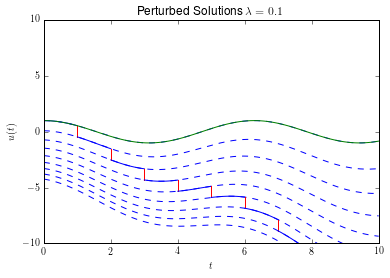

In [17]:
# Plot "inverse hairy" solutions to the ODE
u = lambda t_0, eta, lam, t: numpy.exp(lam * (t - t_0)) * (eta - numpy.cos(t_0)) + numpy.cos(t)

fig = plt.figure()
num_steps = 10
error = numpy.ones(num_steps) * 1.0
t_hat = numpy.linspace(0.0, 10.0, num_steps + 1)
t_whole = numpy.linspace(0.0, 10.0, 1000)

fig = plt.figure()
axes = fig.add_subplot(1, 1, 1)
eta = 1.0
lam = 0.1

for n in xrange(1,num_steps):
    t = numpy.linspace(t_hat[n-1], t_hat[n], 100)
    U = u(t_hat[n-1], eta, lam, t)
    axes.plot(t, U, 'b')
    axes.plot(t_whole, u(t_hat[n-1], eta, lam, t_whole),'b--')
    axes.plot([t[-1], t[-1]], (U[-1], U[-1] + -1.0**n * error[n]), 'r')
    eta = U[-1] + -1.0**n * error[n]

t = numpy.linspace(0.0, 10.0, 100)
axes.plot(t, numpy.cos(t), 'g')

axes.set_title("Perturbed Solutions $\lambda = %s$" % lam)
axes.set_xlabel('$t$')
axes.set_ylabel('$u(t)$')
axes.set_ylim((-10,10))
plt.show()
        

### Example:  Chemical systems

Consider the transition of a chemical $A$ to a chemical $C$ through the process

$$A \overset{K_1}{\rightarrow} B \overset{K_2}{\rightarrow} C.$$

If we let

$$\vec{u} = \begin{bmatrix} [A] \\ [B] \\ [C] \end{bmatrix}$$

then we can model this simple chemical reaction with the system of ODEs

$$\frac{\text{d} \vec{u}}{\text{d} t} = 
\begin{bmatrix}
    -K_1 & 0 & 0 \\
    K_1 & -K_2 & 0 \\
    0 & K_2 & 0
\end{bmatrix} \vec{u}$$

The solution of this system is of the form

$$u_j(t) = c_{j1} e^{-K_1 t} + c_{j2}e^{-K_2 t} + c_{j3}$$

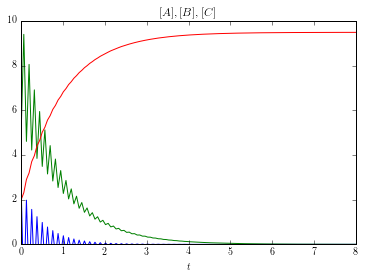

In [18]:
# Solve the chemical systems example
# Problem parameters
# K_1 = 3
# K_2 = 1
K_1 = 30.0
K_2 = 1.0

A = numpy.array([[-K_1, 0, 0], [K_1, -K_2, 0], [0, K_2, 0]])
f = lambda u: numpy.dot(A, u)

t = numpy.linspace(0.0, 8.0, 128)
delta_t = t[1] - t[0]

U = numpy.empty((t.shape[0], 3))
U[0, :] = [2.5, 5.0, 2.0]

for n in xrange(t.shape[0] - 1):
    U[n+1, :] = U[n, :] + delta_t * f(U[n, :])
    
fig = plt.figure()
axes = fig.add_subplot(1, 1, 1)

axes.plot(t, U)

axes.set_title("Chemical System")
axes.set_xlabel("$t$")
axes.set_title("$[A], [B], [C]$")
axes.set_ylim((0.0, 10.))

plt.show()


### What is stiffness?

In general a **stiff** ODE is one where $u'(t) \ll f'(t, u)$.  For systems of ODEs the **stiffness ratio**

$$\frac{\max_p |\lambda_p|}{\min_p |\lambda_p|}$$

can be used to characterize the stiffness of the system.  In our last example this ratio was $K_1 / K_2$ if $K_1 > K_2$.  As we increased this ratio we observed that the numerical method became unstable only a reduction in $\Delta t$ lead to stable solution again.  For explicit time step methods this is problematic as the reduction of the time step for only one of the species leads to very expensive evaluations.  For example, forward Euler has the stability criteria

$$|1 + \Delta t \lambda| < 1$$

where $\lambda$ will have to be the maximum eigenvalue of the system.  

-30.0
-1.0


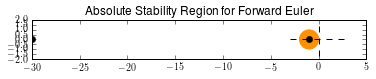

In [19]:
# Plot the region of absolute stability for Forward Euler
fig = plt.figure()
axes = fig.add_subplot(1, 1, 1)

t = numpy.linspace(0.0, 2.0 * numpy.pi, 100)

K_1 = 30.0
K_2 = 1.0
delta_t = 1.0
eigenvalues = [-K_1, -K_2]

axes.fill(numpy.cos(t) - 1.0, numpy.sin(t), color=(255.0/255.0,145.0/255.0,0/255.0,1.0))
for lam in eigenvalues:
    print lam * delta_t
    axes.plot(lam * delta_t, 0.0, 'ko')
axes.plot([-3, 3],[0.0, 0.0],'k--')
axes.plot([0.0, 0.0],[-3, 3],'k--')
# axes.set_xlim((-3, 1))
axes.set_ylim((-2,2))
axes.set_aspect('equal')

axes.set_title("Absolute Stability Region for Forward Euler")
plt.show()

### A-Stability
What if we could expand the absolute stability region to encompass more of the left-half plane or even better, all of it.  A method that has this property is called **A-stable**.  We have already seen one example of this with backward Euler which as a stability region of

$$|1 - z| \geq 1$$

which covers the full left-half plane.  It turns out that for linear multi-step methods a theorem by Dahlquist proves that there are no LMMs that satisfies the A-stability criterion beyond second order (trapezoidal rule).  There are higher-order Runge-Kutta methods do however.

Perhaps this is too restrictive though.  Often large eigenvalues for systems (for instance coming from a PDE discretization for the heat equation) lie completely on the real line.  If the stability region can encompass as much of the real line as possible while leaving out the rest of the left-half plane we can possibly get a more efficient method.  There are a number of methods that can be constructed that have this property but are higher-order.

-3.0
-1.0


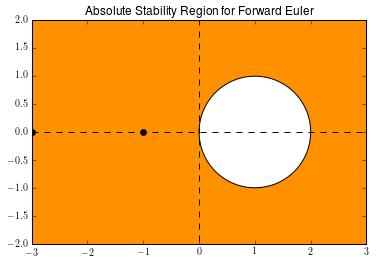

In [20]:
# Plot the region of absolute stability for Forward Euler
fig = plt.figure()
axes = fig.add_subplot(1, 1, 1)

t = numpy.linspace(0.0, 2.0 * numpy.pi, 100)

K_1 = 3.0
K_2 = 1.0
delta_t = 1.0
eigenvalues = [-K_1, -K_2]

axes.set_axis_bgcolor((255.0/255.0,145.0/255.0,0/255.0,1.0))
axes.fill(numpy.cos(t) + 1.0, numpy.sin(t), 'w')
for lam in eigenvalues:
    print lam * delta_t
    axes.plot(lam * delta_t, 0.0, 'ko')
axes.plot([-3, 3],[0.0, 0.0],'k--')
axes.plot([0.0, 0.0],[-3, 3],'k--')
# axes.set_xlim((-3, 1))
axes.set_ylim((-2,2))
axes.set_aspect('equal')

axes.set_title("Absolute Stability Region for Forward Euler")
plt.show()

# L-Stability

It turns out not all A-stable methods are alike.  Consider the backward Euler method and the trapezoidal method defined by

$$\frac{U_{n+1} - U_n}{\Delta t} = \frac{1}{2}(f(U_n) + f(U_{n+1})$$

whose stability polynomial is

$$\begin{aligned}
    0 &= U_{n+1} - U_n - \Delta t \frac{1}{2} (\lambda U_n + \lambda U_{n+1}) \\
      &= U_{n+1}\left(1 - \frac{1}{2} \Delta t \lambda \right ) - U_n \left(1 + \frac{1}{2}\Delta t \lambda \right) \\
      &= \left(\xi - \frac{1 + \frac{1}{2}z}{1 - \frac{1}{2} z}\right) \left(1 - \frac{1}{2} z \right )\\
\end{aligned}$$
which shows that it is A-stable.  Lets apply both these methods to a problem we have seen before and see what happens.

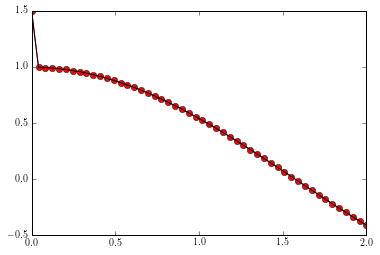

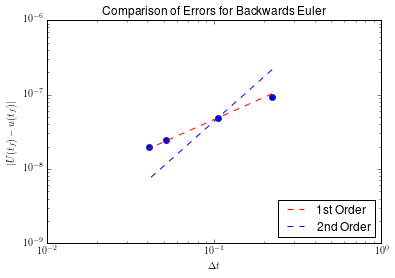

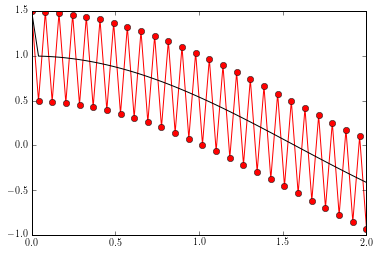

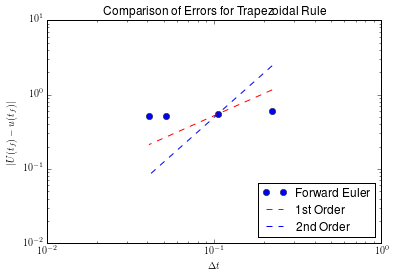

In [21]:
# Compare accuracy between Euler
f = lambda t, lam, u: lam * (u - numpy.cos(t)) - numpy.sin(t)
u_exact = lambda t_0, eta, lam, t: numpy.exp(lam * (t - t_0)) * (eta - numpy.cos(t_0)) + numpy.cos(t)

t_0 = 0.0
eta = 1.5
lam = -1e6

num_steps = [10, 20, 40, 50]

delta_t = numpy.empty(len(num_steps))
error_euler = numpy.empty(len(num_steps))
error_trap = numpy.empty(len(num_steps))

for (i, N) in enumerate(num_steps):
    t = numpy.linspace(0, t_f, N)
    delta_t[i] = t[1] - t[0]
    u = u_exact(t_0, eta, lam, t_f)
    
    # Compute Euler solution
    U_euler = numpy.empty(t.shape)
    U_euler[0] = eta
    for (n, t_n) in enumerate(t[1:]):
        U_euler[n+1] = (U_euler[n] - lam * delta_t[i] * numpy.cos(t_n) - delta_t[i] * numpy.sin(t_n)) / (1.0 - lam * delta_t[i])
    error_euler[i] = numpy.abs(U_euler[-1] - u) / numpy.abs(u)
    
    # Compute using trapezoidal
    U_trap = numpy.empty(t.shape)
    U_trap[0] = eta
    for (n, t_n) in enumerate(t[1:]):
        U_trap[n+1] = (U_trap[n] + delta_t[i] * 0.5 * f(t_n, lam, U_trap[n]) - 0.5 * lam * delta_t[i] * numpy.cos(t_n) - 0.5 * delta_t[i] * numpy.sin(t_n)) / (1.0 - 0.5 * lam * delta_t[i])
    error_trap[i] = numpy.abs(U_trap[-1] - u)
    
# Plot error vs. delta_t
fig = plt.figure()
axes = fig.add_subplot(1, 1, 1)
axes.plot(t, U_euler, 'ro-')
axes.plot(t, u_exact(t_0, eta, lam, t),'k')

fig = plt.figure()
axes = fig.add_subplot(1, 1, 1)

axes.loglog(delta_t, error_euler, 'bo')

order_C = lambda delta_x, error, order: numpy.exp(numpy.log(error) - order * numpy.log(delta_x))
axes.loglog(delta_t, order_C(delta_t[1], error_euler[1], 1.0) * delta_t**1.0, 'r--', label="1st Order")
axes.loglog(delta_t, order_C(delta_t[1], error_euler[1], 2.0) * delta_t**2.0, 'b--', label="2nd Order")

axes.legend(loc=4)
axes.set_title("Comparison of Errors for Backwards Euler")
axes.set_xlabel("$\Delta t$")
axes.set_ylabel("$|U(t_f) - u(t_f)|$")

# Plots for trapezoid
fig = plt.figure()
axes = fig.add_subplot(1, 1, 1)
axes.plot(t, U_trap, 'ro-')
axes.plot(t, u_exact(t_0, eta, lam, t),'k')

fig = plt.figure()
axes = fig.add_subplot(1, 1, 1)

axes.loglog(delta_t, error_trap, 'bo', label='Forward Euler')

order_C = lambda delta_x, error, order: numpy.exp(numpy.log(error) - order * numpy.log(delta_x))
axes.loglog(delta_t, order_C(delta_t[1], error_trap[1], 1.0) * delta_t**1.0, 'r--', label="1st Order")
axes.loglog(delta_t, order_C(delta_t[1], error_trap[1], 2.0) * delta_t**2.0, 'b--', label="2nd Order")

axes.legend(loc=4)
axes.set_title("Comparison of Errors for Trapezoidal Rule")
axes.set_xlabel("$\Delta t$")
axes.set_ylabel("$|U(t_f) - u(t_f)|$")

plt.show()

It turns out that if we look at a one-step method and define the following ratio

$$U_{n+1} = R(z) U_n$$

we can define another form of stability, called **L-stable**, where we require that the method is A-stable and that

$$\lim_{z \rightarrow \infty} |R(z)| = 0.$$

Turns out that backwards Euler is L-stable while trapezoidal rule is not.

## Backward Differencing Formulas

A class of LMM methods that are useful for stiff ODE problems are the backward difference formula (BDF) methods which have the form

$$\alpha_0 U_n + \alpha_1 U_{n+1} + \cdots + \alpha_r U_{n+r} = \Delta \beta_r f(U_{n+r})$$

These methods can be derived directly from backwards finite differences from the point $U_{n+r}$ and the rest of the points back in time.  One can then derive r-step methods that are rth-order accurate this way.  Some of the methods are 

$$\begin{aligned}
    r = 1:& & U_{n+1} - U_n = \Delta t f(U_{n+1}) \\
    r = 2:& &3 U_{n+2} - 4 U_{n+1} + U_n = 2 \Delta t f(U_{n+1}) \\
    r = 3:& &11U_{n+3} - 18U_{n+2} + 9U_{n+1} - 2 U_n = 6 \Delta t f(U_{n+3}) \\
    r = 4:& &25 U_{n+4} - 48 U_{n+3} +36 U_{n+2} -16 U_{n+1} +3 U_n = 12 \Delta t f(U_{n+4})
\end{aligned}$$

## Plotting Stability Regions

If we think of the roots of the stability polynomial $\xi_j$ as complex numbers and write them in exponential form 

$$\xi_j = |\xi_j| e^{i \theta}.$$ 

Here $|\xi_j|$ is the modulus (or magnitude) or the complex number and is defined as $|\xi_j| = x^2 + y^2$ where $\xi_j = x + i j$.  If the $\xi_j$s are on the boundary of the absolute stability region then we know that $|\xi_j| = 1$.  Using this in conjunction with the stability polynomial then leads to 

$$\rho(e^{i\theta}) - z \sigma(e^{i\theta}) = 0$$

which solving for $z$ leads to

$$z(\theta) = \frac{\rho(e^{i\theta})}{\sigma(e^{i\theta})}.$$

This does not necessarily ensure that given a $\theta$ that $z(\theta)$ will lie on the absolute stability region's boundary.  This can occur when $\xi_j = 1$ but to the left and right of the curve $\xi_j > 1$ and so therefore does not mark the boundary of the region.  To determine whether a particular region outlined by this curve is inside or outside of the stability region we can evaluate all the roots of $\pi(\xi, z)$ at some $z$ inside of the region in question and see if then $\forall j, \xi_j < 1$.

For one-step methods this becomes easier, if we look at the ratio $R(z)$ we defined earlier for pth order Taylor series method applied to $u'(t) = \lambda u$ we get

$$\begin{aligned}
    U_{n+1} &= U_n + \Delta t \lambda U_n + \frac{1}{2}\Delta t^2 \lambda^2 U_n + \cdots + \frac{1}{p!}\Delta t^p \lambda^p U_n \\
    &=\left(1 + z + \frac{1}{2} z^2 + \frac{1}{6} z^3 + \cdots +\frac{1}{p!}z^p\right) U_n \Rightarrow \\
    R(z) &= 1 + z + \frac{1}{2} z^2 + \frac{1}{6} z^3 + \cdots +\frac{1}{p!}z^p.
\end{aligned}$$

Setting $R(z) = e^{i\theta}$ could lead to a way for solving for the boundary but (where $|R(z)| = 1$) but this is very difficult to do in general.  Instead if we plot the contours of $R(z)$ in the complex plain we can pick out the $R(z)=1$ contour and plot that.

Forward Euler's method - Stability region tests
  Inside of circle:  0.0
  Outside of circle:  2.0
Backward Euler's method - Stability region tests
  Inside of circle:  2.0
  Outside of circle:  0.0
Backward Euler's method - Stability region tests
  Inside of strange region:  0.0
  Outside of strange region:  3.0


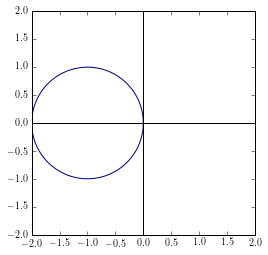

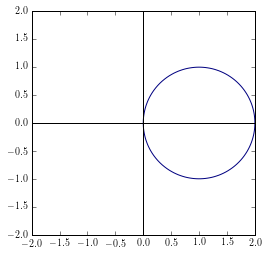

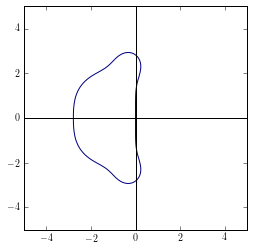

In [24]:
theta = numpy.linspace(0.0, 2.0 * numpy.pi, 100)

# ==================================
#  Forward euler
fig = plt.figure()
axes = fig.add_subplot(1, 1, 1)
x = numpy.linspace(-2, 2, 100)
y = numpy.linspace(-2, 2, 100)
X, Y = numpy.meshgrid(x, y)
Z = X + 1j * Y

# Evaluate which regions are actually in stability region
print "Forward Euler's method - Stability region tests"
z = -1 + 1j * 0
print "  Inside of circle: ", numpy.abs(1.0 + z)
z = -3 + 1j * 0
print "  Outside of circle: ", numpy.abs(1.0 + z)

axes.contour(X, Y, numpy.abs(1.0 + Z), levels=[1.0])
axes.plot(x, numpy.zeros(x.shape),'k')
axes.plot(numpy.zeros(y.shape), y,'k')
axes.set_aspect('equal')

# ==================================
#  Backwards Euler
fig = plt.figure()
axes = fig.add_subplot(1, 1, 1)
x = numpy.linspace(-2, 2, 100)
y = numpy.linspace(-2, 2, 100)
X, Y = numpy.meshgrid(x, y)
Z = X + 1j * Y

# Evaluate which regions are actually in stability region
print "Backward Euler's method - Stability region tests"
z = 1 + 1j * 0
print "  Inside of circle: ", numpy.abs(1.0 + z)
z = -1 + 1j * 0
print "  Outside of circle: ", numpy.abs(1.0 + z)

axes.contour(X, Y, numpy.abs(1.0 / (1.0 - Z)), levels=[1.0])
axes.plot(x, numpy.zeros(x.shape),'k')
axes.plot(numpy.zeros(y.shape), y,'k')
axes.set_aspect('equal')

# ==================================
#  Taylor series method of order 4
fig = plt.figure()
axes = fig.add_subplot(1, 1, 1)
x = numpy.linspace(-5, 5, 100)
y = numpy.linspace(-5, 5, 100)
X, Y = numpy.meshgrid(x, y)
Z = X + 1j * Y

# Evaluate which regions are actually in stability region
print "Backward Euler's method - Stability region tests"
z = -1 + 1j * 0
print "  Inside of strange region: ", numpy.abs(1.0 + z)
z = -4 + 1j * 0
print "  Outside of strange region: ", numpy.abs(1.0 + z)

axes.contour(X, Y, numpy.abs(1 + Z + 0.5 * Z**2 + 1.0/6.0 * Z**3 + 1.0 / 24.0 * Z**4), levels=[1.0])
axes.plot(x, numpy.zeros(x.shape),'k')
axes.plot(numpy.zeros(y.shape), y,'k')
axes.set_aspect('equal')